# Circuit implementation of quantum counting algorithm using Cirq

This notebook will teach you how to construct your own circuits for quantum counting algorithm using Cirq.

# Install Cirq

Install Cirq if you haven't.

In [1]:
!pip install --quiet cirq

     |████████████████████████████████| 409 kB 28.0 MB/s 
     |████████████████████████████████| 1.5 MB 51.2 MB/s 
     |████████████████████████████████| 47 kB 4.8 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 328 kB 74.1 MB/s 
     |████████████████████████████████| 1.3 MB 42.2 MB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
     |████████████████████████████████| 220 kB 63.5 MB/s 
     |████████████████████████████████| 49 kB 7.0 MB/s 
     |████████████████████████████████| 10.1 MB 56.0 MB/s 
     |████████████████████████████████| 52 kB 1.7 MB/s 
     |████████████████████████████████| 65 kB 4.3 MB/s 
     |████████████████████████████████| 97 kB 8.2 MB/s 
     |████████████████████████████████| 28.5 MB 49 kB/s 
     |████████████████████████████████| 15.7 MB 195 kB/s 
     |████████████████████████████████| 229 kB 77.6 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████

# Importing packages

In [2]:
import cirq # No need to explain why
from cirq.contrib.svg import SVGCircuit # Required to display some fancy circuits
import numpy as np # Need it for using pi

#The circuit

Now we move on to the main part of the notebook. In this section, we shall explain the construction of quantum counting circuits. The problem setting is as follows; let $f: \{ 0, 1, \dots, N-1\} \rightarrow \{ 0, 1\}$. Our objective is to count the number of distinct elements $\omega$ in the domain such that $f(\omega)=1$, with minimum number of queries to the function $f$. The quantum counting algorithm solves the problem by combining Grover's search and phase estimation algorithm. Let $G$ be the Grover iterate, that is, $G=U_s U_{\omega}$. The quantum counting circuit is nothing but phase estimation carries out with the operator $G$, and the state $|+\rangle ^ {\otimes \log N}$ prepare in the register where the eigenvectors are prepared. So, the final circuit, with precision of $t$ qubits, is as follows: 

From the measurement output $\phi$, first we compute the eigenvalue of $G$, which is $\lambda =  \frac{2 \pi \phi}{2 ^ t}$. The approximation of the number of satisfiable elements in the domain is given as $N \sin ^ 2 \lambda$.

# Example 1

In this example, consider the function $f: \{ 0,1,2,3\} \rightarrow \{ 0,1\} $ given as

\begin{equation}
  f(x) = 
  \begin{cases}
    1 & \text{ if }x = 1 \ \& \ x = 3 \\
    0 & \text{ otherwise }
  \end{cases}
\end{equation}

This function has two satisfiable solutions $1$ and $3$. In this case $U_{\omega}$ should be an operator of the form

\begin{equation}
  U|x_1 x_2\rangle = 
  \begin{cases}
    -|x_1 x_2 \rangle & \text{ if }x_1 = 1 \\
    |x_1 x_2 \rangle & \text{ otherwise }
  \end{cases}
\end{equation}

This is actually a $Z$ gate applied on the qubit $x_1$.


One can see that the operator $U_s$ does not depend on the function $f$ and it depends only on $N$. When $N=4$ ($2$-qubit case), the circuit for $U_s$ can be seen as

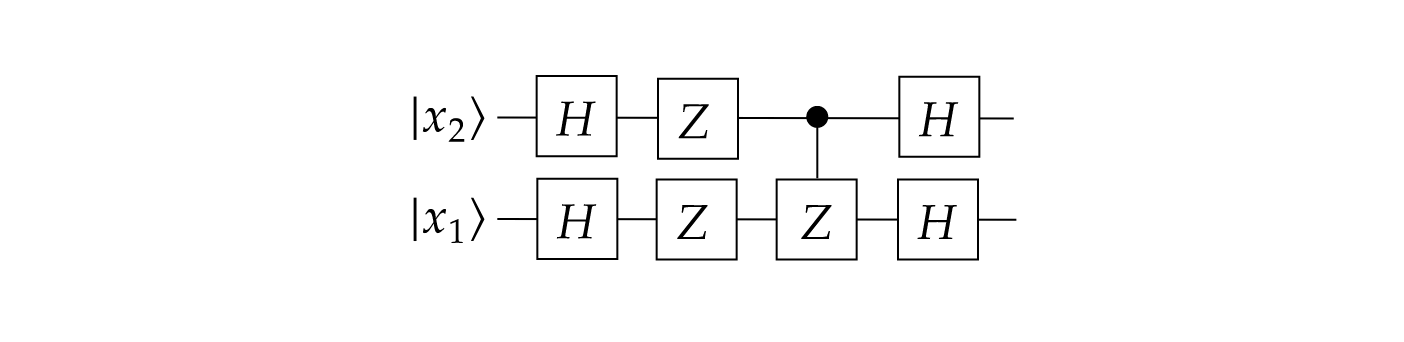

Then, with $2$-qubits in the first register, the final circuit will have the form

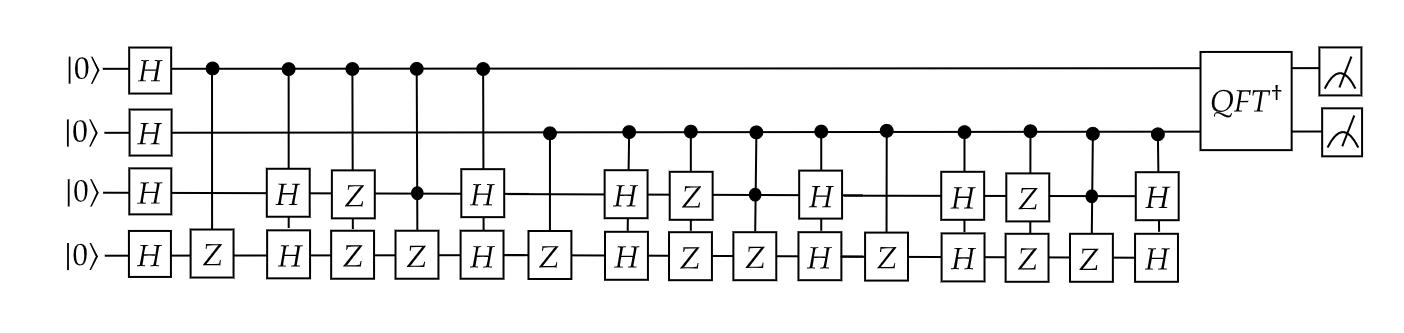

Now, we move on to constructing this circuit using Cirq.

First we initialze a circuit.

In [ ]:
# Prepare circuit 
circuit = cirq.Circuit()

The next step is to initialize the qubits. For this circuit, we require $4$ qubits. 

In [ ]:
# Prepare qubits
q_list = cirq.LineQubit.range(4)

Now, we shall start applying the gates.

Apply Hadamard gates on all qubits

In [ ]:
# Apply Hadamard gate on all qubits
for i in range(4):
  circuit.append(cirq.H(q_list[i]))

Now, we shall start applying controlled-$G ^ {2 ^ j}$ gates.

In [ ]:
for control_qubit in range(2):
  for j in range(2 ** control_qubit):

    # Apply controlled-U_s
    circuit.append(cirq.CZ(q_list[control_qubit], q_list[3]))

    # Apply controlled-U_w
    circuit.append(cirq.H(q_list[2]).controlled_by(q_list[control_qubit]))
    circuit.append(cirq.H(q_list[3]).controlled_by(q_list[control_qubit]))

    circuit.append(cirq.CZ(q_list[control_qubit], q_list[2]))
    circuit.append(cirq.CZ(q_list[control_qubit], q_list[3]))

    circuit.append(cirq.CCZ(q_list[control_qubit], q_list[2], q_list[3]))

    circuit.append(cirq.H(q_list[2]).controlled_by(q_list[control_qubit]))
    circuit.append(cirq.H(q_list[3]).controlled_by(q_list[control_qubit]))

Let's take a break and visualize the circuit.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


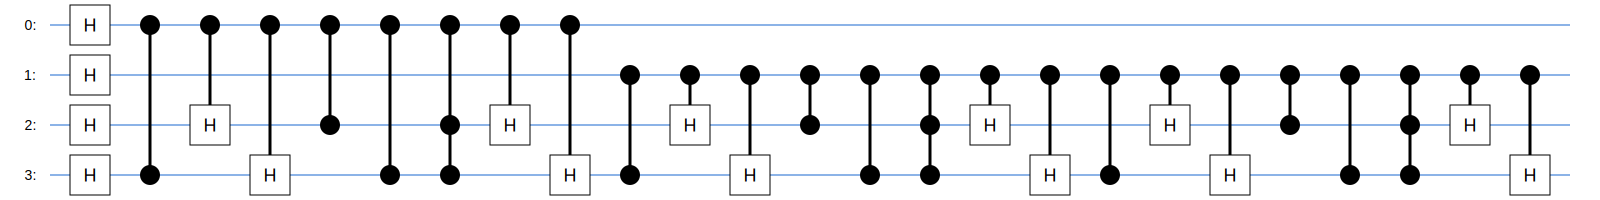

In [ ]:
# Display circuit
SVGCircuit(circuit)

Looks good. The next part is the inverse quantum Fourier transform part.

In [ ]:
# Apply swap gates
circuit.append(cirq.SWAP(q_list[0], q_list[1]))

# Apply controlled-Rk inverse gates
for target_qubit in range(2):
  for control_qubit in range(target_qubit):
    circuit.append(cirq.CZ(q_list[control_qubit], q_list[target_qubit])**(-1/(2 ** (target_qubit-control_qubit))))
  circuit.append(cirq.H(q_list[target_qubit]))

Now, we shall measure, simulate the circuit $1000$ times and analyze the result

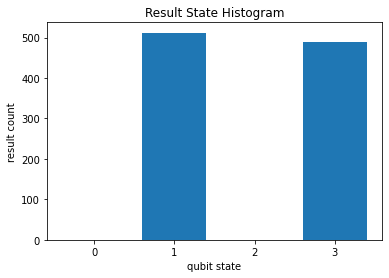

In [ ]:
# Measure
s=cirq.Simulator()
results=s.simulate(circuit, qubit_order = q_list)
circuit.append(cirq.measure(*reversed(q_list[:2]), key='result'))
samples=s.run(circuit, repetitions=1000)

# Plot the results
cirq.vis.plot_state_histogram(samples)

The outputs $1$ and $3$ seem to be equally probable, Now, compute the number of satisfiable elements in the domain from the outputs, in both cases.

In [ ]:
print("Value suggested by output 1: {}".format(4 * (np.sin(1 * np.pi/4) ** 2)))
print("Value suggested by output 3: {}".format(4 * (np.sin(3 * np.pi/4) ** 2)))

Value suggested by output 1: 1.9999999999999996
Value suggested by output 3: 2.0000000000000004


Both measurement outputs point to the correct answer $2$.

# Example 2

In this example, consider the function $f: \{ 0,1,2,3\} \rightarrow \{ 0,1\} $ given as

\begin{equation}
  f(x) = 
  \begin{cases}
    1 & \text{ if }x = 3 \\
    0 & \text{ otherwise }
  \end{cases}
\end{equation}

This function has one satisfiable solution $3$. In this case $U_{\omega}$ should be an operator of the form

\begin{equation}
  U|x_1 x_2\rangle = 
  \begin{cases}
    -|x_1 x_2 \rangle & \text{ if }x_1 = 1 \ \& \ x_2 = 1\\
    |x_1 x_2 \rangle & \text{ otherwise }
  \end{cases}
\end{equation}

This is the controlled-$Z$ gate. Since $U_s$ does not depend upon $f$, we can use the same $U_s$ used in the previous case.


## $3$-qubit precision

In this section, we carry out the quantum counting circuit, with $3$-qubit precision. `

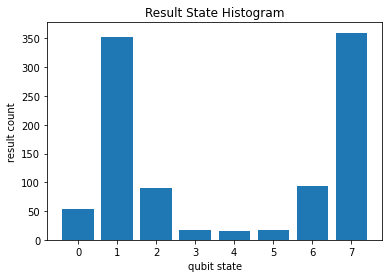

In [ ]:
# Prepare circuit 
circuit = cirq.Circuit()

# Prepare qubits
q_list = cirq.LineQubit.range(5)

# Apply Hadamard gate on all qubits
for i in range(5):
  circuit.append(cirq.H(q_list[i]))

# Apply controlled-G gates
for control_qubit in range(3):
  for j in range(2 ** control_qubit):

    # Apply U_s
    circuit.append(cirq.CCZ(q_list[control_qubit], q_list[3], q_list[4]))
    
    circuit.append(cirq.H(q_list[3]).controlled_by(q_list[control_qubit]))
    circuit.append(cirq.H(q_list[4]).controlled_by(q_list[control_qubit]))

    circuit.append(cirq.CZ(q_list[control_qubit], q_list[3]))
    circuit.append(cirq.CZ(q_list[control_qubit], q_list[4]))

    circuit.append(cirq.CCZ(q_list[control_qubit], q_list[3], q_list[4]))

    circuit.append(cirq.H(q_list[3]).controlled_by(q_list[control_qubit]))
    circuit.append(cirq.H(q_list[4]).controlled_by(q_list[control_qubit]))

    
# Apply inverse QFT
# Apply swap gates
circuit.append(cirq.SWAP(q_list[0], q_list[2]))

# Apply controlled-Rk inverse gates
for target_qubit in range(3):
  for control_qubit in range(target_qubit):
    circuit.append(cirq.CZ(q_list[control_qubit], q_list[target_qubit])**(-1/(2 ** (target_qubit-control_qubit))))
  circuit.append(cirq.H(q_list[target_qubit]))

# Measure
s=cirq.Simulator()
results=s.simulate(circuit, qubit_order = q_list)
circuit.append(cirq.measure(*reversed(q_list[:3]), key='result'))
samples=s.run(circuit, repetitions=1000)

# Plot the results
cirq.vis.plot_state_histogram(samples)

The outputs $1$ and $7$ seem to occur most and equally probable, Now, compute the number of satisfiable elements in the domain from the outputs, in both cases.

In [ ]:
print("Value suggested by output 1: {}".format(4 * (np.sin(1 * np.pi/8) ** 2)))
print("Value suggested by output 7: {}".format(4 * (np.sin(7 * np.pi/8) ** 2)))

Value suggested by output 1: 0.585786437626905
Value suggested by output 7: 0.5857864376269053


We can take a look at the circuit we have executed here.

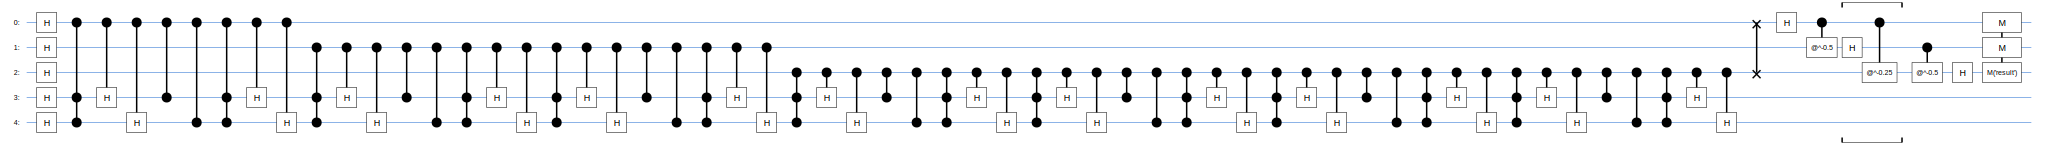

In [ ]:
# Display circuit
SVGCircuit(circuit)

In this case, we are approximately $0.42$ away from the correct answer $1$. Let's see if we can closer to the correct answer by adding more qubits for precision.

## $4$-qubit precision

In the next cell, we run the same phase estimation with $4$ qubit precision.

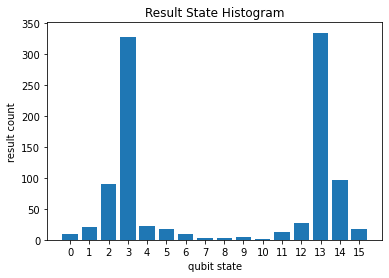

In [3]:
# Prepare circuit 
circuit = cirq.Circuit()

# Prepare qubits
q_list = cirq.LineQubit.range(6)

# Apply Hadamard gate on all qubits
for i in range(6):
  circuit.append(cirq.H(q_list[i]))

# Apply controlled-G gates
for control_qubit in range(4):
  for j in range(2 ** control_qubit):

    # Apply U_s
    circuit.append(cirq.CCZ(q_list[control_qubit], q_list[4], q_list[5]))
    
    circuit.append(cirq.H(q_list[4]).controlled_by(q_list[control_qubit]))
    circuit.append(cirq.H(q_list[5]).controlled_by(q_list[control_qubit]))

    circuit.append(cirq.CZ(q_list[control_qubit], q_list[4]))
    circuit.append(cirq.CZ(q_list[control_qubit], q_list[5]))

    circuit.append(cirq.CCZ(q_list[control_qubit], q_list[4], q_list[5]))

    circuit.append(cirq.H(q_list[4]).controlled_by(q_list[control_qubit]))
    circuit.append(cirq.H(q_list[5]).controlled_by(q_list[control_qubit]))

    
# Apply inverse QFT
# Apply swap gates
circuit.append(cirq.SWAP(q_list[0], q_list[3]))
circuit.append(cirq.SWAP(q_list[1], q_list[2]))

# Apply controlled-Rk inverse gates
for target_qubit in range(4):
  for control_qubit in range(target_qubit):
    circuit.append(cirq.CZ(q_list[control_qubit], q_list[target_qubit])**(-1/(2 ** (target_qubit-control_qubit))))
  circuit.append(cirq.H(q_list[target_qubit]))

# Measure
s=cirq.Simulator()
results=s.simulate(circuit, qubit_order = q_list)
circuit.append(cirq.measure(*reversed(q_list[:4]), key='result'))
samples=s.run(circuit, repetitions=1000)

# Plot the results
cirq.vis.plot_state_histogram(samples)

The outputs $3$ and $13$ seem to occur most and equally probable, Now, compute the number of satisfiable elements in the domain from the outputs, in both cases.

In [4]:
print("Value suggested by output 3: {}".format(4 * (np.sin(3 * np.pi/16) ** 2)))
print("Value suggested by output 13: {}".format(4 * (np.sin(13 * np.pi/16) ** 2)))

Value suggested by output 3: 1.2346331352698203
Value suggested by output 13: 1.2346331352698203


We can take a look at the circuit we have executed here.

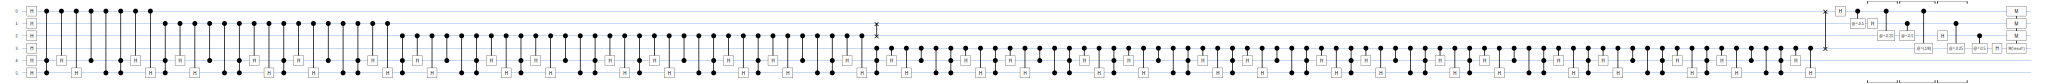

In [ ]:
# Display circuit
SVGCircuit(circuit)

In this case, we are approximately $0.23$ away from the correct answer $1$. Let's see if we can closer to the correct answer by adding more qubits for precision.

##$5$-qubit precision

In the next cell, we run the same phase estimation with $5$ qubit precision.

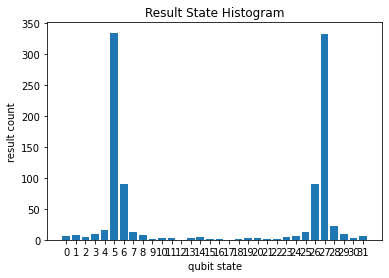

In [5]:
# Prepare circuit 
circuit = cirq.Circuit()

# Prepare qubits
q_list = cirq.LineQubit.range(7)

# Apply Hadamard gate on all qubits
for i in range(7):
  circuit.append(cirq.H(q_list[i]))

# Apply controlled-G gates
for control_qubit in range(5):
  for j in range(2 ** control_qubit):

    # Apply U_s
    circuit.append(cirq.CCZ(q_list[control_qubit], q_list[5], q_list[6]))
    
    circuit.append(cirq.H(q_list[5]).controlled_by(q_list[control_qubit]))
    circuit.append(cirq.H(q_list[6]).controlled_by(q_list[control_qubit]))

    circuit.append(cirq.CZ(q_list[control_qubit], q_list[5]))
    circuit.append(cirq.CZ(q_list[control_qubit], q_list[6]))

    circuit.append(cirq.CCZ(q_list[control_qubit], q_list[5], q_list[6]))

    circuit.append(cirq.H(q_list[5]).controlled_by(q_list[control_qubit]))
    circuit.append(cirq.H(q_list[6]).controlled_by(q_list[control_qubit]))

    
# Apply inverse QFT
# Apply swap gates
circuit.append(cirq.SWAP(q_list[0], q_list[4]))
circuit.append(cirq.SWAP(q_list[1], q_list[3]))

# Apply controlled-Rk inverse gates
for target_qubit in range(5):
  for control_qubit in range(target_qubit):
    circuit.append(cirq.CZ(q_list[control_qubit], q_list[target_qubit])**(-1/(2 ** (target_qubit-control_qubit))))
  circuit.append(cirq.H(q_list[target_qubit]))

# Measure
s=cirq.Simulator()
results=s.simulate(circuit, qubit_order = q_list)
circuit.append(cirq.measure(*reversed(q_list[:5]), key='result'))
samples=s.run(circuit, repetitions=1000)

# Plot the results
cirq.vis.plot_state_histogram(samples)

The outputs $5$ and $27$ seem to occur most and equally probable, Now, compute the number of satisfiable elements in the domain from the outputs, in both cases.

In [6]:
print("Value suggested by output 5: {}".format(4 * (np.sin(5 * np.pi/32) ** 2)))
print("Value suggested by output 27: {}".format(4 * (np.sin(27 * np.pi/32) ** 2)))

Value suggested by output 5: 0.8888595339607955
Value suggested by output 27: 0.8888595339607963


We can take a look at the circuit we have executed here.

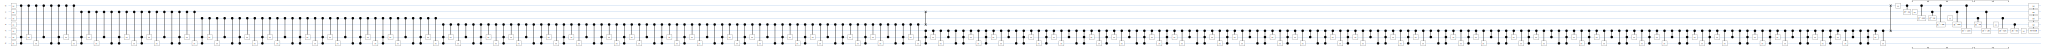

In [ ]:
# Display circuit
SVGCircuit(circuit)

In this case, we are approximately $0.12$ away from the correct answer $1$. 